In [1]:
#importing all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import os
import scipy as stats
from nltk.corpus import stopwords
import re
import string
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import FreqDist
from collections import defaultdict, Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score as cvs
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve , auc
from sklearn.metrics import roc_auc_score
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import pickle

import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv("Dataset_Ratings.csv")
df

,Rating,Review
0,5,The top of the box is little torn otherwise pa...
1,5,Super fast delivery and falous book
2,5,Go for it!! Must read for classical lovers.. M...
3,5,Books were in good condition. Make for a good ...
4,5,Felt happy in getting a box of classical books...
...,...,...
23397,1,Amazing
23398,1,First I was doubtful tat will it come safely w...
23399,1,Nice product
23400,1,Value for money and looks awesome while wearing


# Data Inspection

In [3]:
df.shape

(23402, 2)

There are 23402 rows and 2 columns in the dataset.

In [4]:
df.dtypes

Rating     int64
Review    object
dtype: object

One column is of integer data type and another is of Object type.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23402 entries, 0 to 23401
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Rating  23402 non-null  int64 
 1   Review  23167 non-null  object
dtypes: int64(1), object(1)
memory usage: 365.8+ KB


By observing the info we can say that there are some null values in the dataset and since all the datatype of dataset is object it means all the entries are string entries.

# Data Cleaning

In [6]:
df.isnull().sum()

Rating      0
Review    235
dtype: int64

There are few null values in column 'Review' and we will treat them using mode imputation method.

<AxesSubplot:>

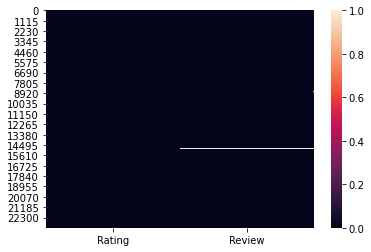

In [7]:
sns.heatmap(df.isnull())

Visual representation of having null values in the dataset.

In [8]:
#Checking the mode of Review column
df["Review"].mode()

0    Good
dtype: object

So the highest occuring Review is Good, we have to replace the nan values in Review column with it's mode.

In [9]:
#Replacing naa values with there mode as the column is categorical
df["Review"] = df["Review"].fillna(df["Review"].mode()[0])

In [10]:
#checking the null values again
df.isnull().sum()

Rating    0
Review    0
dtype: int64

There are no null values in the dataset.

# Text Analysis

Let's have a look into our Review column and see first 2 entries how the data looks:

In [11]:
# Checking data of first row in Review column
df['Review'][0]

'The top of the box is little torn otherwise packaging is good.\n2- Books conditions are totally fine.\n3- Paper material and printing is bright and fair.'

In [12]:
# Checking data of second row in Review column
df['Review'][1]

' Super fast delivery and falous book'

By observing the Reviews we can say that there are many words, numbers, as well as punctuations which are not important for our predictions. So we need to do good text processing.

# Text Processing

In [13]:
#Here I am defining a function to replace some of the abbreviations to their full form and removing urls and some unwanted text 
def decontracted(text):
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don’t", "do not", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"im ", "i am", text)
    text = re.sub(r"yo ", "you ",text)
    text = re.sub(r"doesn’t", "does not",text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"<br>", " ", text)
    text = re.sub(r'http\S+', '', text) #removing urls
    return text

# Changing all words to there Lowercase
df['Review'] = df['Review'].apply(lambda x : x.lower())

df['Review'] = df['Review'].apply(lambda x : decontracted(x))

# Removing punctuations
df['Review'] = df['Review'].str.replace('[^\w\s]','')
df['Review'] = df['Review'].str.replace('\n','')

# Changing all words to there Lowercase
df['Review'] = df['Review'].apply(lambda x : x.lower())

df['Review'] = df['Review'].apply(lambda x : decontracted(x))

# Removing punctuations
df['Review'] = df['Review'].str.replace('[^\w\s]','')
df['Review'] = df['Review'].str.replace('\n','')

### Let's have a look into our text again:

In [14]:
# Checking data of first row in Review column again
df['Review'][0]

'the top of the box is little torn otherwise packaging is good2 books conditions are totally fine3 paper material and printing is bright and fair'

### Removing StopWords:

In [15]:
# Removing stopwords
stop = stopwords.words('english')
df['Review'] = df['Review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

# Checking the text data again
df['Review'][0]

'top box little torn otherwise packaging good2 books conditions totally fine3 paper material printing bright fair'

Now we have removed all stop words from the text data.

### Lemmatization:

In [16]:
#Initialising lemmatizer
lemmatizer = nltk.stem.WordNetLemmatizer()
#Defining functiom to convert nltk tag to wordnet tags
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None
    
#defining function to lemmatize our text
def lemmatize_sentence(sentence):
    #tokenize the sentence & find the pos tag
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x : (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatize_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatize_sentence.append(word)
        else:
            lemmatize_sentence.append(lemmatizer.lemmatize(word,tag))
    return " ".join(lemmatize_sentence)

df['Review'] = df['Review'].apply(lambda x : lemmatize_sentence(x))

# Checking the text data again
df['Review'][0]

'top box little torn otherwise package good2 book condition totally fine3 paper material print bright fair'

So now we have removed the inflectional endings and left out with the base or dictionary form of a word.

### Text Normalization - Standardization:

In [17]:
#Noice removal
def scrub_words(text):
    #remove html markup
    text = re.sub("(<.*?>)", "", text)
    #remove non-ascii and digits
    text = re.sub("(\\W)", " ", text)
    text = re.sub("(\\d)", "", text)
    #remove white space
    text = text.strip()
    return text

df['Review'] = df['Review'].apply(lambda x : scrub_words(x))

# Checking the text data again
df['Review'][0]

'top box little torn otherwise package good book condition totally fine paper material print bright fair'

Finally I have defined a function scrub_words for removing the noise from the text. It will remove any html markups, digits and white spaces from the text.

# Exploratory Data Analysis

## i) Word Counts:

In [18]:
# Creating column for word counts in the text
df['Review_WordCount'] = df['Review'].apply(lambda x: len(str(x).split(' ')))
df[['Review_WordCount','Review']].head()

,Review_WordCount,Review
0,16,top box little torn otherwise package good boo...
1,5,super fast delivery falous book
2,36,go must read classical lover might difficult s...
3,34,book good condition make good read bad part se...
4,10,felt happy get box classical booksthe book goo...


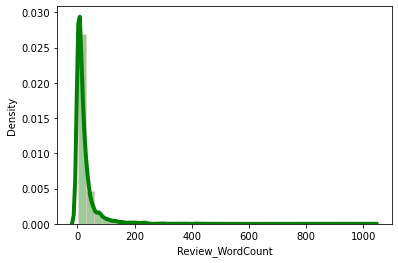

In [19]:
# density plot and histogram of Review word count
sns.distplot(df['Review_WordCount'], hist = True, kde = True,
            bins = int(180/5), color = 'green',
            hist_kws = {'edgecolor':'pink'},
            kde_kws = {'linewidth':4})
plt.show()

By observing the histogram we can clearly see that most of our text is having the number of words in the range of 0 to 200, But some of the reviews are too lengthy which may act like outliers in our data.

## ii) Character count:

In [20]:
# Creating column for character counts in the text
df['Review_ChaCount'] = df['Review'].str.len()
df[['Review_ChaCount','Review']].head()

,Review_ChaCount,Review
0,103,top box little torn otherwise package good boo...
1,31,super fast delivery falous book
2,216,go must read classical lover might difficult s...
3,228,book good condition make good read bad part se...
4,75,felt happy get box classical booksthe book goo...


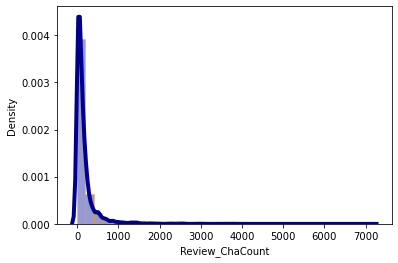

In [21]:
# density plot and histogram of all character count
sns.distplot(df['Review_ChaCount'], hist = True, kde = True,
            bins = int(180/5), color = 'darkblue',
            hist_kws = {'edgecolor':'orange'},
            kde_kws = {'linewidth':4})
plt.show()

Above plot represents histogram for character count of Review text, which is quite similar to the histogram of word count.

### Treating Outliers

In [22]:
# Applying zscore to remove outliers
from scipy import stats
from scipy.stats import zscore
z_score = zscore(df[['Review_WordCount']])
abs_z_score = np.abs(z_score)
filtering_entry = (abs_z_score < 3).all(axis = 1)
df = df[filtering_entry]
df.shape

(22966, 4)

In [23]:
print('Data Loss after removing outliers:',((23402-22966)/23402)*100,'%')

Data Loss after removing outliers: 1.8630886249038543 %


By removing the outliers we are loosing 1.86% of data which is very less and it is in acceptable range.

### Plotting histograms for word count and character counts again after removing outliers:

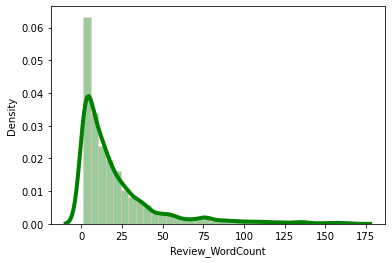

In [24]:
# density plot and histogram of Review word count
sns.distplot(df['Review_WordCount'], hist = True, kde = True,
            bins = int(180/5), color = 'green',
            hist_kws = {'edgecolor':'pink'},
            kde_kws = {'linewidth':4})
plt.show()

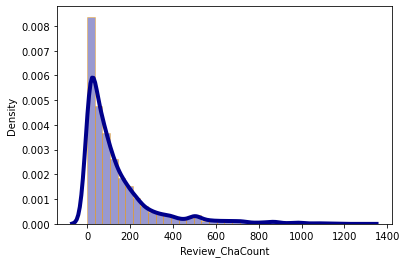

In [25]:
# density plot and histogram of all character count
sns.distplot(df['Review_ChaCount'], hist = True, kde = True,
            bins = int(180/5), color = 'darkblue',
            hist_kws = {'edgecolor':'orange'},
            kde_kws = {'linewidth':4})
plt.show()

After plotting histograms for word counts and character counts and after removing outliers we can see we are left with descent range of number of words and characters.

## iii) Top 30 most frequently occuring words:

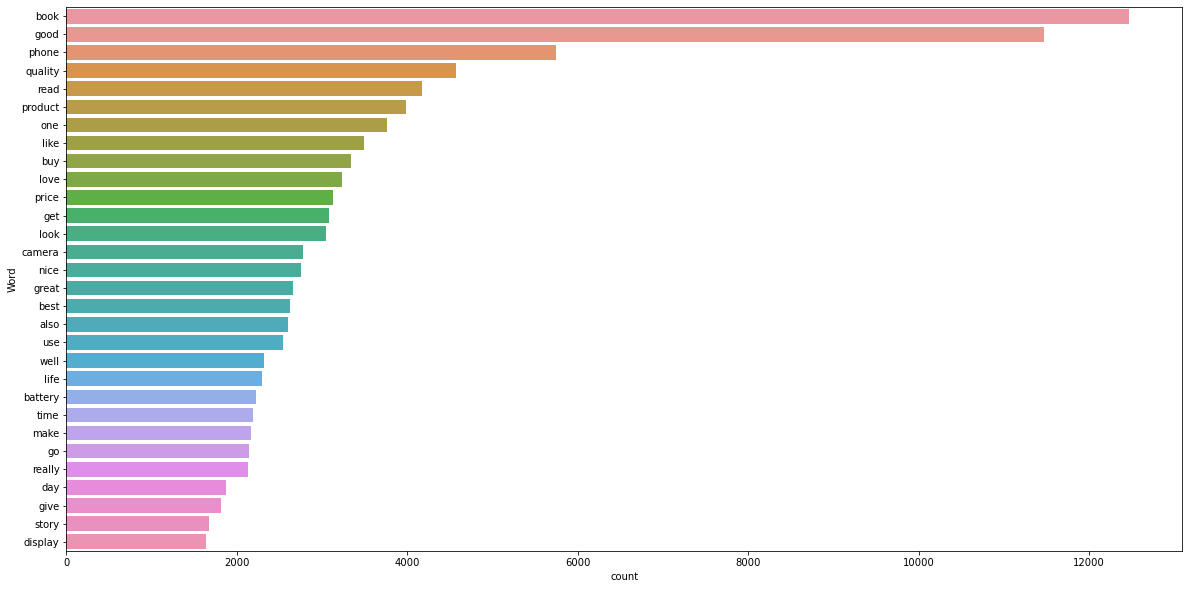

In [26]:
#function to plot most frequent terms
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()
    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()),
                             'count':list(fdist.values())})
    #selecting top 30 most freq words
    d = words_df.nlargest(columns = 'count', n = terms)
    plt.figure(figsize = (20,10))
    ax = sns.barplot(data = d, x='count', y='word')
    ax.set(ylabel = 'Word')
    plt.show()
    
freq_words(df['Review'])    

By seeing the above plot we can see that book, good, phone, quality......are occurring frequently.

## iv) Word cloud:

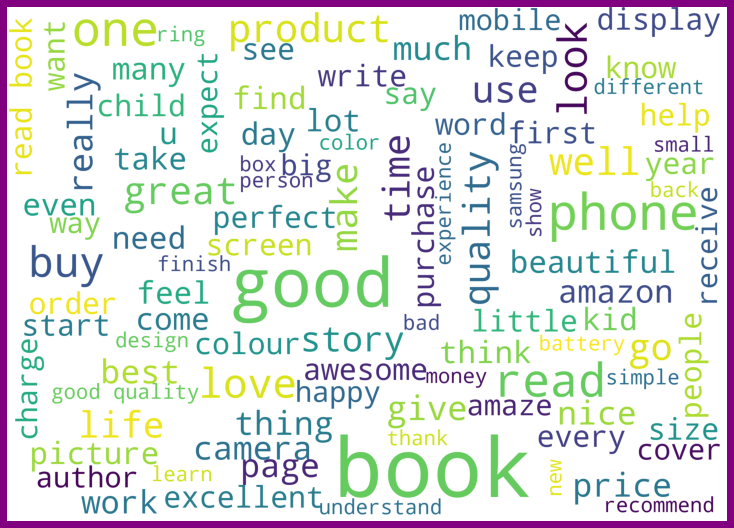

In [27]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
                    background_color='white',
                    stopwords = stopwords,
                    max_words = 500,
                    max_font_size = 40,
                    scale = 3,
                    random_state = 1).generate(str(data))
    fig = plt.figure(1, figsize=(15,15))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)
    plt.imshow(wordcloud)
    plt.show()
    
#Let's plot the loud words with Rating 1
from wordcloud import WordCloud

df1=df['Review'][df['Rating']==1]

spam_cloud = WordCloud(width=700,height=500,background_color='white',stopwords = stopwords,max_words = 100,max_font_size = 80,scale = 3,random_state = 1).generate(' '.join(df1))

plt.figure(figsize=(10,8),facecolor='purple')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

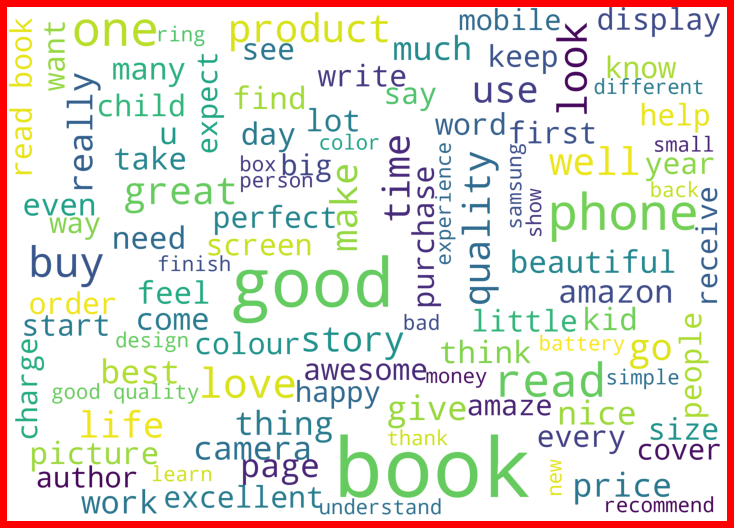

In [28]:
#Let's plot the loud words with Rating 2
from wordcloud import WordCloud

df2=df['Review'][df['Rating']==2]

spam_cloud = WordCloud(width=700,height=500,background_color='white',stopwords = stopwords,max_words = 100,max_font_size = 80,scale = 3,random_state = 1).generate(' '.join(df1))

plt.figure(figsize=(10,8),facecolor='red')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()


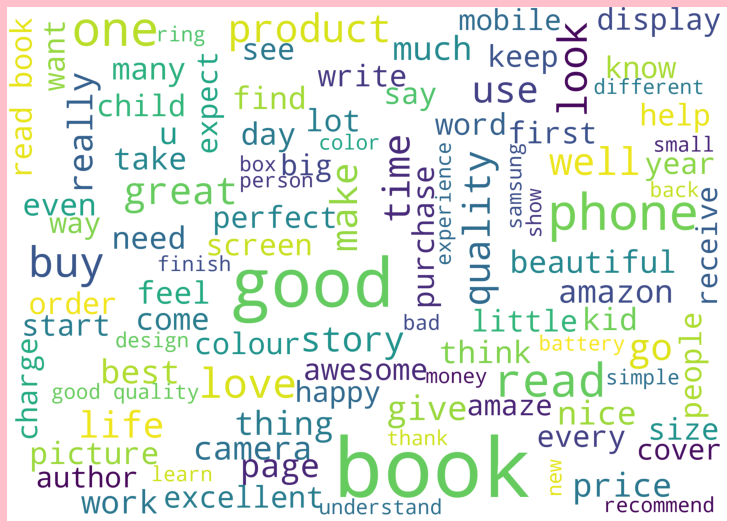

In [29]:
#Let's plot the loud words with Rating 3
from wordcloud import WordCloud

df3=df['Review'][df['Rating']==3]

spam_cloud = WordCloud(width=700,height=500,background_color='white',stopwords = stopwords,max_words = 100,max_font_size = 80,scale = 3,random_state = 1).generate(' '.join(df1))

plt.figure(figsize=(10,8),facecolor='pink')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

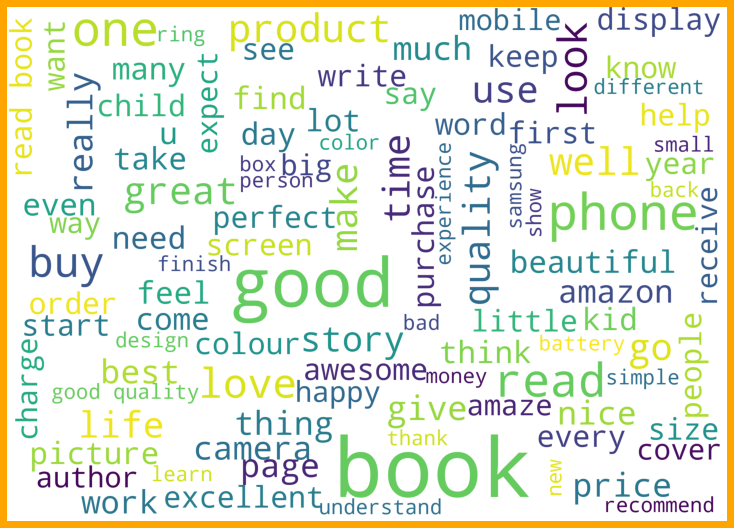

In [30]:
#Let's plot the loud words with Rating 4
from wordcloud import WordCloud

df4=df['Review'][df['Rating']==4]

spam_cloud = WordCloud(width=700,height=500,background_color='white',stopwords = stopwords,max_words = 100,max_font_size = 80,scale = 3,random_state = 1).generate(' '.join(df1))

plt.figure(figsize=(10,8),facecolor='orange')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)

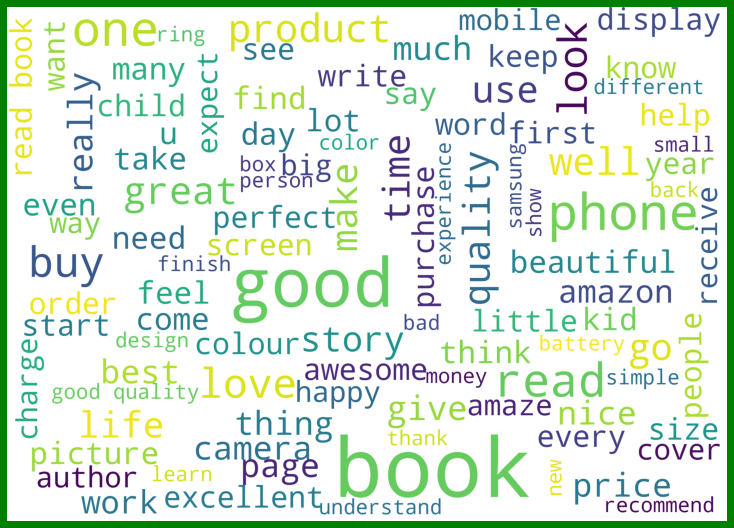

In [31]:
#Let's plot the loud words with Rating 5
from wordcloud import WordCloud

df5=df['Review'][df['Rating']==5]

spam_cloud = WordCloud(width=700,height=500,background_color='white',stopwords = stopwords,max_words = 100,max_font_size = 80,scale = 3,random_state = 1).generate(' '.join(df1))

plt.figure(figsize=(10,8),facecolor='g')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)

#### Observations:
From the above plots we can clearly see the words which are indication of Reviewer's opinion on products.
Here most frequent words used for each Rating is displayed in the word cloud.

## v) Balancing the Dataset

<AxesSubplot:xlabel='Rating', ylabel='count'>

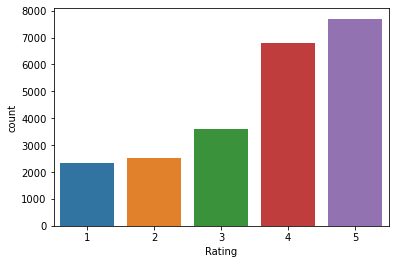

In [32]:
sns.countplot(df['Rating'])

In [33]:
# Separating feature and label
x = df['Review']
y = df['Rating']

### Converting text data into vectors using Tfidf Vectorizer:

In [34]:
#using the n_gram tfidf vectorizer(Word vectors)
from sklearn.feature_extraction.text import TfidfVectorizer
word_vectorizer = TfidfVectorizer(
                                sublinear_tf = True,
                                strip_accents = 'unicode',
                                analyzer = 'word',
                                token_pattern = r'\w{1,}',
                                stop_words = 'english',
                                ngram_range = (1,3),
                                max_features = 100000)
word_vectorizer.fit(x)
train_word_features = word_vectorizer.transform(x)

#Character vectorizer
char_vectorizer = TfidfVectorizer(
                                sublinear_tf = True,
                                strip_accents = 'unicode',
                                analyzer = 'char',
                                stop_words = 'english',
                                ngram_range = (2,6),
                                max_features = 50000)
char_vectorizer.fit(x)
train_char_features = char_vectorizer.transform(x)

#I will combine both word vectors and character vectors as input for our model
from scipy.sparse import hstack
train_features = hstack([train_char_features,train_word_features])

In [35]:
x_train, x_test, y_train, y_test = train_test_split(train_features, y, test_size = 0.25, random_state = 5)

#Checking the number of classes before fit
from collections import Counter
print("The number of classes before fit{}".format(Counter(y_train)))

The number of classes before fitCounter({5: 5792, 4: 5117, 3: 2705, 2: 1880, 1: 1730})


So we have maximum count 5792 for 5 star ratings hence will over sample all the ratings to the mark 5769.

In [36]:
# Oversample and plot imbalanced dataset with SMOTE
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE

# transforming the dataset
os=SMOTE(sampling_strategy = {1: 5792, 2: 5792, 3: 5792, 4: 5792, 5: 5792})
x_train_ns,y_train_ns=os.fit_resample(x_train,y_train)

print("The number of classes before fit{}".format(Counter(y_train)))
print("The number of classes after fit {}".format(Counter(y_train_ns)))

The number of classes before fitCounter({5: 5792, 4: 5117, 3: 2705, 2: 1880, 1: 1730})
The number of classes after fit Counter({5: 5792, 4: 5792, 3: 5792, 1: 5792, 2: 5792})


# Model Building

Accuracy Score of MultinomialNB is 0.21455938697318008
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       596
           2       0.00      0.00      0.00       630
           3       0.08      0.00      0.00       906
           4       0.07      0.07      0.07      1699
           5       0.27      0.59      0.37      1911

    accuracy                           0.21      5742
   macro avg       0.08      0.13      0.09      5742
weighted avg       0.12      0.21      0.14      5742

AxesSubplot(0.125,0.125;0.62x0.755)


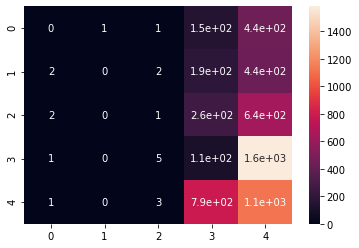

In [37]:
mnb = MultinomialNB()
mnb.fit(x_train,y_train)
mnb.score(x_train_ns,y_train_ns)
predmnb=mnb.predict(x_test)
print('Accuracy Score of MultinomialNB is',accuracy_score(y_test,predmnb))
cm= confusion_matrix(y_test,predmnb)
print(classification_report(y_test,predmnb))
print(sns.heatmap(cm,annot=True))

Accuracy Score of Logistic Regression is 0.1469871125043539
              precision    recall  f1-score   support

           1       0.09      0.02      0.03       596
           2       0.01      0.00      0.00       630
           3       0.01      0.00      0.00       906
           4       0.08      0.10      0.09      1699
           5       0.21      0.35      0.26      1911

    accuracy                           0.15      5742
   macro avg       0.08      0.09      0.08      5742
weighted avg       0.11      0.15      0.12      5742

AxesSubplot(0.125,0.125;0.62x0.755)


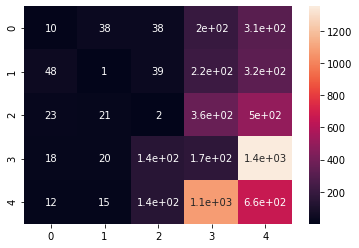

In [38]:
lr = LogisticRegression(solver='lbfgs')
lr.fit(x_train,y_train)
lr.score(x_train_ns,y_train_ns)
predlr=lr.predict(x_test)
print('Accuracy Score of Logistic Regression is',accuracy_score(y_test,predlr))
cm= confusion_matrix(y_test,predlr)
print(classification_report(y_test,predlr))
print(sns.heatmap(cm,annot=True))

Accuracy Score of BernoulliNB is 0.20916057122953674
              precision    recall  f1-score   support

           1       0.01      0.01      0.01       596
           2       0.02      0.01      0.02       630
           3       0.08      0.09      0.08       906
           4       0.25      0.43      0.31      1699
           5       0.33      0.20      0.25      1911

    accuracy                           0.21      5742
   macro avg       0.14      0.15      0.13      5742
weighted avg       0.20      0.21      0.19      5742

AxesSubplot(0.125,0.125;0.62x0.755)


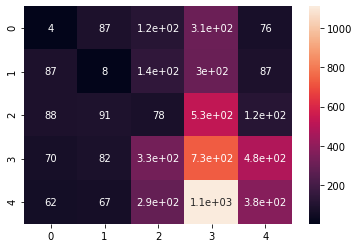

In [39]:
bnb = BernoulliNB()
bnb.fit(x_train,y_train)
bnb.score(x_train_ns,y_train_ns)
predbnb=bnb.predict(x_test)
print('Accuracy Score of BernoulliNB is',accuracy_score(y_test,predbnb))
cm= confusion_matrix(y_test,predbnb)
print(classification_report(y_test,predbnb))
print(sns.heatmap(cm,annot=True))

Accuracy score of SGDClassifier is 0.12608847091605713
              precision    recall  f1-score   support

           1       0.07      0.10      0.08       596
           2       0.03      0.04      0.03       630
           3       0.02      0.02      0.02       906
           4       0.11      0.08      0.09      1699
           5       0.25      0.25      0.25      1911

    accuracy                           0.13      5742
   macro avg       0.10      0.10      0.10      5742
weighted avg       0.13      0.13      0.13      5742

AxesSubplot(0.125,0.125;0.62x0.755)


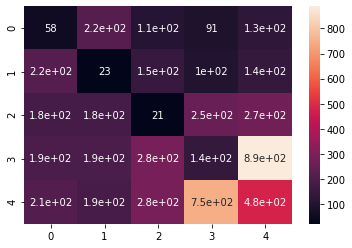

In [40]:
sgd=SGDClassifier()
sgd.fit(x_train_ns,y_train_ns)
sgd.score(x_train_ns,y_train_ns)
predsgd=sgd.predict(x_test)
print('Accuracy score of SGDClassifier is',accuracy_score(y_test,predsgd))
cm=confusion_matrix(y_test,predsgd)
print(classification_report(y_test,predsgd))
print(sns.heatmap(cm,annot=True))

In [41]:
gc = GradientBoostingClassifier(random_state=9)
gc.fit(x_train_ns,y_train_ns)
gc.score(x_train_ns,y_train_ns)
predgc=gc.predict(x_test)
print('Accuracy Score of GradientBoostingClassifier is',accuracy_score(y_test,predgc))
cm=confusion_matrix(y_test,predgc)
print(classification_report(y_test,predgc))

Accuracy score of GradientBoostingClassifier is 0.52608847091605713
              precision    recall  f1-score   support


       1       0.17      0.20      0.18       596
       2       0.13      0.14      0.13       630
       3       0.12      0.12      0.12       906
       4       0.21      0.18      0.19      1699
       5       0.35      0.35      0.35      1911


    accuracy                           0.53      5742
   macro avg       0.20      0.20      0.20      5742
weighted avg       0.23      0.23      0.23      5742


In [42]:
rf = RandomForestClassifier()
rf.fit(x_train_ns,y_train_ns)
rf.score(x_train_ns,y_train_ns)
predrf=rf.predict(x_test)
print('Accuracy score of RandomForestClassifier is',accuracy_score(y_test,predrf))
cm=confusion_matrix(y_test,predrf)
print(classification_report(y_test,predrf))

Accuracy score of RandomForestClassifier is 0.58608847091605713
              precision    recall  f1-score   support


       1       0.67      0.70      0.68       596
       2       0.16      0.14      0.13       630
       3       0.26      0.19      0.22       906
       4       0.29      0.48      0.39      1699
       5       0.75      0.65      0.75      1911


    accuracy                           0.59      5742
   macro avg       0.43      0.42      0.43      5742
weighted avg       0.58      0.56      0.56      5742


Accuracy score of DecisionTree Classifier is 0.10031347962382445
              precision    recall  f1-score   support

           1       0.02      0.04      0.03       596
           2       0.01      0.01      0.01       630
           3       0.03      0.03      0.03       906
           4       0.11      0.09      0.10      1699
           5       0.25      0.19      0.22      1911

    accuracy                           0.10      5742
   macro avg       0.08      0.07      0.08      5742
weighted avg       0.12      0.10      0.11      5742

AxesSubplot(0.125,0.125;0.62x0.755)


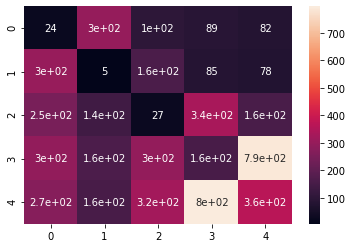

In [43]:
dt = DecisionTreeClassifier()
dt.fit(x_train_ns,y_train_ns)
dt.score(x_train_ns,y_train_ns)
preddt=dt.predict(x_test)
print('Accuracy score of DecisionTree Classifier is',accuracy_score(y_test,preddt))
cm=confusion_matrix(y_test,preddt)
print(classification_report(y_test,preddt))
print(sns.heatmap(cm,annot=True))

# Cross Validation Score

In [44]:
print("CVS for MultinomialNB =",cvs(mnb,x,y,cv=3).mean()*100,"%")
print("CVS for Logistic Regression =",cvs(lr,x,y,cv=3).mean()*100,"%")
print("CVS for BernoulliNB =",cvs(bnb,x,y,cv=3).mean()*100,"%")
print("CVS for SGDClassifier =",cvs(sgd,x,y,cv=3).mean()*100,"%")
print("CVS for GradientBoostingClassifier =",cvs(gc,x,y,cv=3).mean()*100,"%")
print("CVS for Random Forest Classifier =",cvs(rf,x,y,cv=3).mean()*100,"%")
print("CVS for DecisionTree Classifier =",cvs(dt,x,y,cv=3).mean()*100,"%")

CVS for MultinomialNB = 25.455938697318008 %
CVS for Logistic Regression = 18.69871125043539 %
CVS for BernoulliNB = 25.916057122953674 %
CVS for SGDClassifier = 12.608847091605713 %
CVS for GradientBoostingClassifier = 0.51608847091605713 %
CVS for Random Forest Classifier = 58.598847091605713 %
CVS for DecisionTree Classifier = 0.09031347962382445 %


From the Accuracy score and Cross validation score , we choose 'RandomForestClassifier' for hyper parameter tuning as it has the high accuracy and least difference between accuracy score and cross validation score.

# Hyper Parameter Tuning

In [45]:
parameter={'n_estimators':np.arange(50,300,50),
          'criterion':['gini','entropy'],
          'max_features':['auto','sqrt','log2'],
          'class_weight':['balanced', 'balanced_subsample']}
gvc = GridSearchCV(RandomForestClassifier(),parameter,cv=5)
gvc.fit(x_train_ns,y_train_ns)
gvc.best_params_

{'class_weight': 'balanced'
 'criterion': 'gini' 
 'max_features': 'log2' 
 'n_estimators': 150 }


We get the best parameters to be used in RandomForestClassifier() to increase it's accuracy.

# Final Model

In [46]:
Rate = RandomForestClassifier(criterion='gini', n_estimators=150, max_features='log2', class_weight='balanced')
Rate.fit(x_train_ns,y_train_ns)
pred=Rate.predict(x_test)
acc=accuracy_score(y_test,pred)
print("Accuracy of RandomForestClassifier is ", acc*100, "%")
print(classification_report(y_test,pred))

Accuracy score of RandomForestClassifier is 0.58908847091605713
              precision    recall  f1-score   support


       1       0.67      0.70      0.78       596
       2       0.13      0.24      0.13       630
       3       0.32      0.22      0.22       906
       4       0.21      0.48      0.39      1699
       5       0.75      0.65      0.65      1911


    accuracy                           0.59      5742
   macro avg       0.44      0.46      0.45      5742
weighted avg       0.63      0.53      0.53      5742


# Model Saving

In [47]:
import joblib
joblib.dump(model,"Ratings.pkl")

Finally I have saved the model into .pkl file.